# What's New in Tidy3d?

This notebook will walk through the changes that have been made in the major release of Tidy3d.

If you are a new user and not familiar with our beta version, this tutorial can be useful, but you may rather see one of our other ones for a more direct walkthrough of the features.

In [1]:
# First, lets import the main packages we'll need
import numpy as np
import matplotlib.pylab as plt
import tidy3d as td

## Global Changes

Here we will discuss some of the general changes that apply to all Tidy3d importable components.

Topics covered will include:
* Defining Tidy3d components.
* Saving and loading from file.
* Getting help / debugging.
* logging

### Background

All Tidy3d components are defined using the [pydantic](https://pydantic-docs.helpmanual.io) package.  As such, each tidy3d object corresponds to a data structure that has rigidly defined allowable types and values, which get validated automatically whenever you inialize an object.

This has several advantges, including.
* Catching bugs in the tidy3d components as early as possible.
* Automatically generated schema for tidy3d simulation specifications.
* Simple and reliable IO.

### Defining Tidy3d Components

It also requires a bit more due-diligence on the user side:
* All tidy3d components must use keyword arguments in their definitions, eg. `Medium(2.0)` becomes `Medium(permittivity=2.0)` to be explicit.
* Correct types must be provided where conversion is not possible, for example if `td.Simulation()` takes a `grid_size` argument that is declared as a tuple of floats, it can't be specified as a single float `dl` and should be instead supplied directly as `(dl, dl, dl)`.

In [3]:
# wrong way
try:
    td.Medium(2.0)
except Exception as e:
    td.log.info(e)

# correct way
m = td.Medium(permittivity=2.0)

[20:09:38] INFO     __init__() takes exactly 1 positional argument (2 given)  ]8;id=615474;file:///var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_85691/2256051156.py\2256051156.py]8;;\:]8;id=136868;file:///var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_85691/2256051156.py#5\5]8;;\

In [4]:
# wrong way
try:
    s = td.Simulation(size=(1, 1, 1), grid_size=.1)
except Exception as e:
    td.log.info(e)

# correct way
s = td.Simulation(size=(1,1,1), grid_size=(1, 1, 1))

[20:09:40] INFO     1 validation error for Simulation                         ]8;id=677936;file:///var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_85691/3716715587.py\3716715587.py]8;;\:]8;id=984459;file:///var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_85691/3716715587.py#5\5]8;;\
                    grid_size                                                                
                      value is not a valid tuple (type=type_error.tuple)

### Saving and Loading Tidy3d Components

All tidy3d components can be saved to file as json or yaml format using the `instance.to_file(path)` and `class.from_file(path)` methods.

For example, let's save and load a `td.Box()` instance.

In [5]:
my_box = td.Box(center=(1,2,3), size=(2,2,3))

my_box.to_file('data/box.json')

# note, `from_file` is a @classmethod so need to call it from `td.Box` not `my_box`.
your_box = td.Box.from_file('data/box.json')

print(my_box)
print(your_box)

center=(1.0, 2.0, 3.0) type='Box' size=(2.0, 2.0, 3.0)
center=(1.0, 2.0, 3.0) type='Box' size=(2.0, 2.0, 3.0)


### Getting Help

Sometimes you might want to get some information about a component without needing to look at the documentation.  For this, each tidy3d component has a `.help()` method that will print out information about the stored data inside of the component.

Here's an example.

In [6]:
monitor = td.FieldMonitor(size=(2,2,0), freqs=[200e12], name='monitor')

monitor.help()

╭──────────────────── <class 'tidy3d.components.monitor.FieldMonitor'> ─────────────────────╮
│ :class:`Monitor` that records electromagnetic fields in the frequency domain.             │
│                                                                                           │
│ ╭───────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ FieldMonitor(center=(0.0, 0.0, 0.0), type='FieldMonitor', size=(2.0, 2.0, 0.0),       │ │
│ │ name='monitor', freqs=[200000000000000.0], fields=['Ex', 'Ey', 'Ez', 'Hx', 'Hy',      │ │
│ │ 'Hz'])                                                                                │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│ bounding_box = Box(center=(0.0, 0.0, 0.0), type='Box', size=(2.0, 2.0, 0.0))              │
│       bounds = ((-1.0, -1.0, 0.0), (1.0, 1.0, 0.0))                                       │
│       center = (0.0, 0.0, 0.0)                                                            │
│       fields = ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz']                                       │
│        freqs = [200000000000000.0]                                                        │
│     geometry = Box(center=(0.0, 0.0, 0.0), type='Box', size=(2.0, 2.0, 0.0))              │
│         name = 'monitor'                                                                  │
│         size = (2.0, 2.0, 0.0)                                                            │
│         type = 'FieldMonitor'                                                             │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

## Changes to Core Components

Here we will discuss the changes to the core package, specifically changes to how the core components (sources, monitors, etc) are defined.

Topics covered will include:
* Mediums.
* Geometries.
* Structures.
* Sources.
* Monitors.
* Modes.
* PML / Absorbing boundaries.
* Simulations.

### Mediums

As before, mediums define the optical properties of the materials within the simulation.

#### PEC
The simplest medium is `td.PEC`, which just signifies a perfect electrical conductor (no E field allowed within).

In [8]:
pec_medium = td.PEC

#### Non-dispersive mediums
Non-dispersive mediums are defined using the `td.Medium()` object and can be specified by either `permittivity` and `conductivity` (optional) values, or from `n`, `k` refractive index values.

In [9]:
lossless_dielectric = td.Medium(permittivity=4.0)
lossy_dielectric = td.Medium(permittivity=4.0, conductivity=1.0)
lossy_dielectric_from_nk = td.Medium.from_nk(n=2.0, k=0.1, freq=150e12)

#### Anisotropic mediums

Tidy3d only supports *diagonally* anisotropic media without dispersion.

This kind of medium can be simply defined by specifing three `td.Medium` objects for the xx, yy, zz components of the permittivity / conductivity tensor.


In [10]:
anisotropic_medium = td.AnisotropicMedium(
    xx=lossless_dielectric,
    yy=lossy_dielectric,
    zz=lossy_dielectric_from_nk
)

#### Dispersive mediums

Dispersive mediums can be defined in three ways:

* Imported from our `td.material_library`.
* Defined directly by specifying the parameters in the various supplied dispersive models.
* Fitted to optical n-k data using the dispersion fitting tool plugin (more info later).

In [11]:
# material library
silver_variants = td.material_library['Ag']
print('variants for silver include: ', list(silver_variants.keys()))
silver = silver_variants['JohnsonChristy1972']

# models
lorentz_model = td.Lorentz(eps_inf=2.0, coeffs=[(1,2,3), (4,5,6)])
sellmeier_model = td.Sellmeier(coeffs=[(1,2), (3,4)])

variants for silver include:  ['Rakic1998', 'JohnsonChristy1972']


### Medium Methods

The complex-valued permittivity of a medium at a given frequency can be sampled using the `.eps_model(freq)` method.

And the n, k values can be plotted over a frequency range using the `.plot(freqs)` method.

complex relative permittivity at freqs_hz = 
	 [4.+359.50208038j 4.+358.42679998j 4.+357.35793278j ... 4. +90.0105359j
 4. +89.94297733j 4. +89.87552009j]



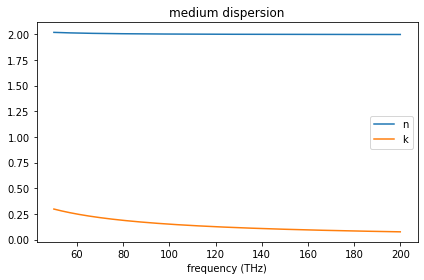

In [12]:
freqs_hz = 1e12 * np.linspace(50, 200, 1001)
print(f'complex relative permittivity at freqs_hz = \n\t {lossy_dielectric.eps_model(freqs_hz)}\n')

ax = lossy_dielectric_from_nk.plot(freqs_hz)

### Geometries

The new version of Tidy3D introduces `td.Geometry` objects, which do the heavy lifting for any components with some spatial extent.

There are only 4 primitive geometries:
* Box
* Sphere
* Cylinder
* Polyslab

Note that `GdsSlab` was removed, but GDS cells can still be loaded as `PolySlab` objects using `PolySlab.from_gds()` classmethod.  Please refer to the tutorial notebook on GDS importing for more details.

Geometry objects have many useful methods.

True
False
((-1.0, -1.0, -1.0), (1.0, 1.0, 1.0))


╭─────────────────── <class 'tidy3d.components.geometry.Box'> ────────────────────╮
│ Rectangular prism.                                                              │
│ Also base class for :class:`Simulation`, :class:`Monitor`, and :class:`Source`. │
│                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────╮ │
│ │ Box(center=(0.0, 0.0, 0.0), type='Box', size=(2.0, 2.0, 2.0))               │ │
│ ╰─────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                 │
│ bounding_box = Box(center=(0.0, 0.0, 0.0), type='Box', size=(2.0, 2.0, 2.0))    │
│       bounds = ((-1.0, -1.0, -1.0), (1.0, 1.0, 1.0))                            │
│       center = (0.0, 0.0, 0.0)                                                  │
│     geometry = Box(center=(0.0, 0.0, 0.0), type='Box', size=(2.0, 2.0, 2.0))    │
│         size = (2.0, 2.0, 2.0)                                                  │
│         type = 'Box'                                                            │
╰─────────────────────────────────────────────────────────────────────────────────╯

None
False
[False False  True False False]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])


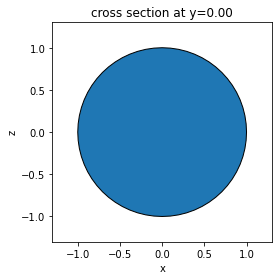

In [13]:
s1 = td.Sphere(radius=1, center=(0,0,0))
s2 = td.Box(center=(1, 1, 1), size=(1, 1, 1))

# do two geometric object intersect?
print(s1.intersects(s2))

# does the object intersect a plane?
print(s1.intersects_plane(z=10))

# get polygons that intersect sphere at plane x=0
print(s1.intersections(x=0))

# get bounds (rmin, rmax) of geometry
print(s1.bounds)

# get td.Box() for bounding box of geometry
print(s1.bounding_box.help())

# evaluate whether point(s) are inside of geometry
print(s1.inside(x=0, y=1, z=1))
print(s1.inside(x=np.linspace(-1, 1, 5), y=np.zeros(5), z=np.ones(5)))

# plot the geometry at a cross sectional plane
ax = s1.plot(y=0)

Note, because Simulations, Monitors, and Sources all are defined spatially, they inherit from td.Box() and contain these methods as well, which can come in handy when doing validation.

### Structures

The new version of tidy3d redefines the notion of `Structure` as something that simply contains a `Geometry` and a `Medium`.  Therefore, the call structure is a bit different.

In [14]:
# old way
try:
    dielectric_box = td.Structure(
        center=(0,0,0),
        size=(1,1,1),
        medium=td.Medium(permittivity=2.0))
except Exception as e:
    td.log.info(e)

# new way
dielectric_box = td.Structure(
    geometry=td.Box(
        center=(0,0,0),
        size=(1,1,1)
    ),
    medium=td.Medium(permittivity=2.0)
)

[20:10:46] INFO     3 validation errors for Structure                         ]8;id=236860;file:///var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_85691/1190380030.py\1190380030.py]8;;\:]8;id=719567;file:///var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_85691/1190380030.py#8\8]8;;\
                    geometry                                                                 
                      field required (type=value_error.missing)                              
                    center                                                                   
                      extra fields not permitted (type=value_error.extra)                    
                    size                                                                     
                      extra fields not permitted (type=value_error.extra)

### Sources

Sources work more or less similarly to the old version, with a few minor API changes.

1. `PointDipole` and `VolumeSource` were combined into a single `VolumeSource` object.  For a dipole, specify the `size=(0,0,0)`.

2. Instead of specifying injection axis, plane wave, mode source, and gaussian beam sources must have a planar geometry (one size=0 element) and `direction` (`'+'` or `'-'`) specifying the direction along the normal axis to send the fields.


In [16]:
# note the change in kwarg values
gaussian = td.GaussianPulse(freq0=150e12, fwidth=10e12)

# z polarized dipole at origin
dipole = td.VolumeSource(
    center=(0,0,0),
    size=(0,0,0),
    source_time=gaussian,
    polarization='Ez'
)

# z polarized plane wave propagating in -x
plane_wave = td.PlaneWave(
    center=(0,0,0),
    size=(0, td.inf, td.inf),
    source_time=gaussian,
    pol_angle=np.pi/2,
    direction='-'
)

### Monitors

Monitors have received some major changes in the new version.
Before, monitors were split up according to whether they measured values in the time or frequency domain.
* TimeMonitor
* FreqMonitor
The contents of the `store` argument told the solver what kind of data to load into the monitor data.

In the new version, each monitor stores a single type of data and we have expanded the number of monitors.

The following monitors measure their corresponding values in the frequency-domain

* FieldMonitor
* FluxMonitor
* ModeMonitor

And the following measure their values in the time-domain

* FieldTimeMonitor
* FluxTimeMonitor

This splitting up of monitor types means less accounting about what values are stored, and each monitor type has a corresponding data type in the simulation data.

Otherwise, monitors function very similarly, with a few minor API changes.

Note: all monitors must be *named* (have a `name` argument supplied).  The data returned by the server will be indexed by the monitor name.

In [17]:
# measures Ex, Ey, Hz fields on the plane at frequency 150THz
mon1 = td.FieldMonitor(
    center=(1,0,0),
    size=(td.inf, td.inf, 0),
    fields=['Ex', 'Ey', 'Hz'],
    freqs=[150e12],
    name='fields_at_150THz'
)

# measures time dependence of flux through a plane every 5 time steps between a window of (start, stop)
mon2 = td.FluxTimeMonitor(
    center=(1,0,0),
    size=(td.inf, td.inf, 0),
    start=1e-13,
    stop=3e-13,
    interval=5,
    name='flux_over_time',
)

### Modes

Mode objects have also gone through major revisions.

In the previous versions of Tidy3D, there were convenience functions for viewing mode profiles (`Simulation.viz_modes`), and ultimately the mode information needed to be set manually using `Simulation.set_mode()`.

In the new version, we introduce a `td.ModeSpec()` object that stores all of the specifiction needed for the mode solver to know which modes to inject or measure in the `ModeSource` and `ModeMonitor` objects.

For example:

In [20]:
# default mode solver spec (returns first mode)
fundamental = td.ModeSpec()

# tell the mode solver to return 4 modes
first_4_modes = td.ModeSpec(num_modes=4)

# have mode solver return 4 modes around the target effective index
complicated = td.ModeSpec(num_modes=4, target_neff=2.0)

Using the mode specifications, we can make modal sources or monitors similar to before.

In [50]:
# inject the fundamental mode
mode_source = td.ModeSource(
    center=(0, 0, -1),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    mode_spec=fundamental,
    mode_index=0,
    direction='+'
)

# do modal decomposition and return amplitude data for the first 4 modes
mode_mon = td.ModeMonitor(
    center=(0, 0, +1),
    size=(td.inf, td.inf, 0),
    freqs=freqs_hz,
    mode_spec=first_4_modes,
    name='modes'
)

The `td.plugins.ModeSolver()` is designed to help users come up with the correct `Mode` for their problem, at which point it can be used directly in `ModeSource` and `ModeMonitor` objects without setting it explicitly using a `Simulation` method.  For more details, refer to the mode solver tutorial notebook.

### Absorbing Boundaries

Absorbing boundaries are defined a bit differently in the new version, there are three types of boundaries

* `td.PML()` defines a standard PML, with an adjustable number of layers.
* `td.StablePML()` defines a PML with 'stable' profile, which can reduce divergence at the expense of more layers.
* `td.Absorber()` defines adiabatically increasing conductivity values at the edges of the simultion, which can dramatically improve stability of simulations involving dispersive materials, again at the expense of more layers.

As before, these layers *add* to the simulation size defined in `Simulation`.

Also as before, it is important to extend any structures all the way through the PML if they are meant to be touching the simulation boundary on that side.

To define a sequence of PML lyers on the x, y, z sides of the simulation, one my define a tuple contining either the pml lyer values or `None` if no PML is to be added on that side.

Periodic boundaries are always used on each side of the simultion, so if the PML is `None` on one side, the simulation will be periodic.

In [21]:
# standard absorber on x, PML with 20 layers on y, no PML on z (periodic BC)
pml_layers = [td.Absorber(), td.PML(num_layers=20), None]

### Simulations

Finally, as before, `Simulation` objects contain all of the specifications needed to run the Tidy3D simulation and contain all of the previous components.

Again, there are some minor API changes, but overall they look very similar.

* `Simulation` accepts an optional `medium` parameter, specifying the background medium (air by default).
* `mesh_step` and `resolution` were removed in favor of a `grid_size` tuple of dx, dy, dz size of each unit cell.

In [23]:
sim = td.Simulation(
    size=(10,10,10),
    grid_size=(.1, .1, .1),
    run_time=1e-12,
    pml_layers=[None, td.PML(), None],
    structures=[dielectric_box],
    sources=[dipole],
    monitors=[mon1, mon2],
)

A defined `Simulation` also provides several useful methods in addition to the ones inhereted from `td.Box`.

x=array([-4.95, -4.85, -4.75, -4.65, -4.55, -4.45, -4.35, -4.25, -4.15,
       -4.05, -3.95, -3.85, -3.75, -3.65, -3.55, -3.45, -3.35, -3.25,
       -3.15, -3.05, -2.95, -2.85, -2.75, -2.65, -2.55, -2.45, -2.35,
       -2.25, -2.15, -2.05, -1.95, -1.85, -1.75, -1.65, -1.55, -1.45,
       -1.35, -1.25, -1.15, -1.05, -0.95, -0.85, -0.75, -0.65, -0.55,
       -0.45, -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,
        0.45,  0.55,  0.65,  0.75,  0.85,  0.95,  1.05,  1.15,  1.25,
        1.35,  1.45,  1.55,  1.65,  1.75,  1.85,  1.95,  2.05,  2.15,
        2.25,  2.35,  2.45,  2.55,  2.65,  2.75,  2.85,  2.95,  3.05,
        3.15,  3.25,  3.35,  3.45,  3.55,  3.65,  3.75,  3.85,  3.95,
        4.05,  4.15,  4.25,  4.35,  4.45,  4.55,  4.65,  4.75,  4.85,
        4.95]) y=array([-6.15, -6.05, -5.95, -5.85, -5.75, -5.65, -5.55, -5.45, -5.35,
       -5.25, -5.15, -5.05, -4.95, -4.85, -4.75, -4.65, -4.55, -4.45,
       -4.35, -4.25, -4.15, -4.05, -3.95, -3.85, -3.75, -3.65, -3.55,
 

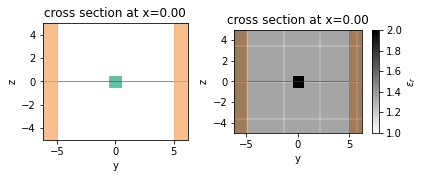

In [27]:
# get permittivity at yee cell centers in a volume defined by a box.
sim.epsilon(td.Box(size=(1,0,1)), 'centers')

# get a `td.Grid` containing all information about spatial locations in the FDTD / yee grid
print(sim.grid.centers)

# plot the simulation cross section
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True)

# plot the structures, PML, sources, mediums
ax1 = sim.plot(x=0, ax=ax1)

# same thing but plot structure in grayscale using permittivity value
ax1 = sim.plot_eps(x=0, ax=ax2)

# add the FDTD grid boundaries
ax2 = sim.plot_grid(x=0, ax=ax2)

## Changes to Simulation Submission

Here we will discuss changes made to the process for submitting, managing, monitoring, and loading simulations from our server.

Topics covered will include:
* `tidy3d.web` interface.
* working with `Job` and `Batch` convenience containers.

In [28]:
import tidy3d.web as web

Using Tidy3D credentials from stored file


### Web interface

The new web interface provides the same functions as the original version with a few major changes.

* `task_id = web.upload(sim, task_name)` accepts the original `Simulation` object, whereas in the old version one had to convert it to a dictionary using `sim.export()` first. 
* `web.upload()` returns the task_id directly, rather than the task info dictionary.  To get the detailed task info run `web.get_info(task_id)`
* `task_id = web.upload(sim, task_name)` uploads the simulation as a `draft=True`, meaning it will not start running automatically unless explicitly told to with `web.start(task_id)`.

Usually, the most convenient way to run a single simulation in one line is with `web.run()`, which simply performs all of the necessary steps one by one.

Note, in the new version, the output of the simultion is a separate data object called a `td.SimulationData`.  Whereas before it was a `Simulation` object with the data loaded inside of it.  We will discuss this is more detail in the following section.

In [29]:
sim_data = web.run(sim, task_name='web_demo', path='data/data.hdf5')

[20:15:57] INFO     Uploaded task 'web_demo' with task_id                       ]8;id=306509;file://../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=32047;file://../../tidy3d/tidy3d/web/webapi.py#109\109]8;;\
                    '3eb2faca-7d94-4384-b52c-1e8192155212'.

Output()

[20:16:18] status = preprocess                                                  ]8;id=68634;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=747789;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[20:16:45] status = running                                                     ]8;id=265432;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=733237;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[20:17:09] status = postprocess                                                 ]8;id=141152;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=278037;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[20:17:23] status = visualize                                                   ]8;id=561727;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=412206;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[20:17:35] status = success                                                     ]8;id=476667;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=782468;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#201\201]8;;\

[20:17:36] INFO     downloading file "monitor_data.hdf5" to "data/data.hdf5"    ]8;id=428982;file://../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=19794;file://../../tidy3d/tidy3d/web/webapi.py#476\476]8;;\

Output()

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[20:17:38] INFO     loading SimulationData from data/data.hdf5                  ]8;id=195439;file://../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=994356;file://../../tidy3d/tidy3d/web/webapi.py#306\306]8;;\

### Containers

The new version also contains the convenience containers `Job` and `Batch` for managing single and multiple tasks without needing to account for the `task_id` and other metadata.

They follow the same basic API as the `web.` functions, except `Batch` objects return generators that can be iterated through to give `SimulationData` for each task, rather than returning it one by one.  This cuts down on memory for several large jobs.  

While we wont cover all of the details here, for more information, see the `WebAPI` notebook or look at the examples in the other notebooks.

## Changes to Output Data

Here we will discuss changes made to the output data from a simulation.

Topics covered will include:
* `SimulationData` objects.
* Obtaining information about a completed FDTD simulation.
* Selecting data by monitor or field value.
* Post-processing and visualizing data.

### Simulation Data

As mentioned, tidy3d data is now separated from the `Simulation` object that led to its creation.

We call the data container for a single task a `SimulationData` object.

In addition to storing the data for each of the individual monitors in the simulation, it has it's own useful functionality.

In [30]:
# print the log, which is stored as an attribute rather than as its own file
print(sim_data.log)

# get a copy of the original Simulation, so it also doesnt need to be stored separately
sim_data.simulation.help()

Simulation domain Nx, Ny, Nz: [100, 124, 100]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 1.2400e+06.
Using subpixel averaging: True
Number of time steps: 5.7710e+03
Automatic shutoff factor: 1.00e-05
Time step (s): 1.7332e-16
Compute source modes time (s):     0.0697
Compute monitor modes time (s):    0.0434

Rest of setup time (s):            0.1671

Starting solver...
- Time step    230 / time 3.99e-14s (  4 % done), field decay: 1.00e+00
- Time step    459 / time 7.96e-14s (  7 % done), field decay: 1.00e+00
- Time step    461 / time 7.99e-14s (  8 % done), field decay: 1.00e+00
- Time step    692 / time 1.20e-13s ( 12 % done), field decay: 9.85e-02
- Time step    923 / time 1.60e-13s ( 16 % done), field decay: 5.51e-02
- Time step   1154 / time 2.00e-13s ( 20 % done), field decay: 4.53e-02
- Time step   1385 / time 2.40e-13s ( 24 % done), field decay: 3.24e-02
- Time step   1615 / time 2.80e-13s ( 28 % done), field decay: 2.70e-02
- Time step   1846 / time 3

╭──────────────────── <class 'tidy3d.components.simulation.Simulation'> ────────────────────╮
│ Contains all information about Tidy3d simulation.                                         │
│                                                                                           │
│ ╭───────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ Simulation(center=(0.0, 0.0, 0.0), type='Simulation', size=(10.0, 10.0, 10.0),        │ │
│ │ grid_size=(0.1, 0.1, 0.1), medium=Medium(name=None, frequency_range=None,             │ │
│ │ type='Medium', permittivity=1.0, conductivity=0.0), run_time=1e-12,                   │ │
│ │ structures=[Structure(geometry=Box(center=(0.0, 0.0, 0.0), type='Box', size=(1.0,     │ │
│ │ 1.0, 1.0)), medium=Medium(name=None, frequency_range=None, type='Medium',             │ │
│ │ permittivity=2.0, conductivity=0.0), name=None, type='Structure')],                   │ │
│ │ sources=[VolumeSource(center=(0.0, 0.0, 0.0), type='VolumeSource', size=(0.0, 0.0,    │ │
│ │ 0.0), source_time=GaussianPulse(amplitude=1.0, phase=0.0, type='GaussianPulse',       │ │
│ │ freq0=150000000000000.0, fwidth=10000000000000.0, offset=5.0), name=None,             │ │
│ │ polarization='Ez')], monitors=[FieldMonitor(center=(1.0, 0.0, 0.0),                   │ │
│ │ type='FieldMonitor', size=(1000000000000.0, 1000000000000.0, 0.0),                    │ │
│ │ name='fields_at_150THz', freqs=[150000000000000.0], fields=['Ex', 'Ey', 'Hz']),       │ │
│ │ FluxTimeMonitor(center=(1.0, 0.0, 0.0), type='FluxTimeMonitor',                       │ │
│ │ size=(1000000000000.0, 1000000000000.0, 0.0), name='flux_over_time', start=1e-13,     │ │
│ │ stop=3e-13, interval=5)], pml_layers=(PML(num_layers=0,                               │ │
│ │ parameters=PMLParams(sigma_order=3, sigma_min=0.0, sigma_max=1.5, type='PMLParams',   │ │
│ │ kappa_order=3, kappa_min=1.0, kappa_max=3.0, alpha_order=1, alpha_min=0.0,            │ │
│ │ alpha_max=0.0), type='PML'), PML(num_layers=12, parameters=PMLParams(sigma_order=3,   │ │
│ │ sigma_min=0.0, sigma_max=1.5, type='PMLParams', kappa_order=3, kappa_min=1.0,         │ │
│ │ kappa_max=3.0, alpha_order=1, alpha_min=0.0, alpha_max=0.0), type='PML'),             │ │
│ │ PML(num_layers=0, parameters=PMLParams(sigma_order=3, sigma_min=0.0, sigma_max=1.5,   │ │
│ │ type='PMLParams', kappa_order=3, kappa_min=1.0, kappa_max=3.0, alpha_order=1,         │ │
│ │ alpha_min=0.0, alpha_max=0.0), type='PML')), symmetry=(0, 0, 0), shutoff=1e-05,       │ │
│ │ subpixel=True, courant=0.9, version='0.2.0')                                          │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│    bounding_box = Box(center=(0.0, 0.0, 0.0), type='Box', size=(10.0, 10.0, 10.0))        │
│          bounds = ((-5.0, -5.0, -5.0), (5.0, 5.0, 5.0))                                   │
│          center = (0.0, 0.0, 0.0)                                                         │
│         courant = 0.9                                                                     │
│              dt = 1.7332498780330734e-16                                                  │
│ frequency_range = (100000000000000.0, 200000000000000.0)                                  │
│        geometry = Box(center=(0.0, 0.0, 0.0), type='Box', size=(10.0, 10.0, 10.0))        │
│            grid = Grid(boundaries=Coords(x=array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5,     │
│                   -4.4, -4.3, -4.2, -4.1, -4. ,                                           │
│                          -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. ,      │
│                   -2.9,                                                                   │
│                          -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9,      │
│                   -1.8,                           

### Monitor Data

Data for each monitor is stored as its own `td.MonitorData` instance.

Whereas before we needed to access data using `sim.data(monitor)`, now we can access the data by `monitor.name` from the `SimulationData` using square brackets.

The data are stored as [xarray](http://xarray.pydata.org/en/stable/) objects, which means they work similar to numpy arrays but provide many additional useful features.  For more details refer to the `VizData` notebook.

<xarray.Tidy3dDataArray (t: 231)>
array([-0.76135159, -0.82072926, -1.37289476, -1.19095552, -0.67030013,
       -0.77215058, -1.13126111, -1.01368546, -0.72327483, -0.80191958,
       -1.02917624, -1.01633644, -0.87647533, -0.88055706, -1.0364784 ,
       -1.14619231, -1.06711292, -0.96508706, -1.11651731, -1.33869553,
       -1.22673202, -1.02181721, -1.23500633, -1.52410841, -1.3007102 ,
       -1.03797865, -1.35965705, -1.64059019, -1.26751292, -1.02301323,
       -1.46107984, -1.65127861, -1.14513958, -0.99796391, -1.51581347,
       -1.55552459, -0.98106229, -0.98103249, -1.51136887, -1.38672245,
       -0.82880473, -0.97639507, -1.45022845, -1.19687188, -0.7236408 ,
       -0.97384363, -1.3510375 , -1.0344131 , -0.66996258, -0.95961607,
       -1.24438393, -0.9252044 , -0.64694673, -0.93129754, -1.16185534,
       -0.86494106, -0.62830317, -0.90440667, -1.12069774, -0.82670635,
       -0.60243022, -0.90284133, -1.11288679, -0.77982211, -0.57858312,
       -0.93909162, -1.1084092

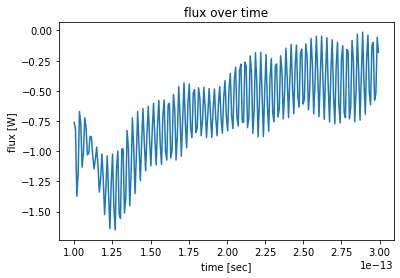

In [31]:
flux_data = sim_data['flux_over_time']
print(flux_data)
flux_data.plot()
plt.title('flux over time')
plt.show()

For field data, we can further index by `fields` specified in the monitor, as follows.

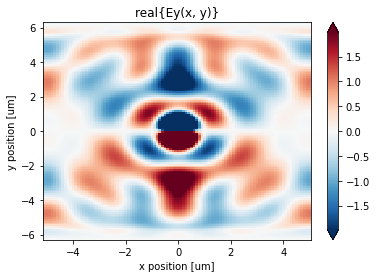

In [34]:
Ey = sim_data['fields_at_150THz'].Ey

Ey.real.interp(z=0).plot(x='x', y='y', robust=True)
plt.title('real{Ey(x, y)}')
plt.show()

Finally, `SimulationData` provides a method for potting field data with structure overlay, similar to `sim.viz_fields2D()`.

In [ ]:
sim_data.plot_field('fields_at_150THz', 'Ey', val='real', z=0, freq=150e12)
plt.show()

## Plugins

Here we will discuss the plugins that support and extend functionalities of Tidy3D, including:
* Dispersion fitting tool.
* Mode solver.
* Near field to far field transformations.

These plugins are designed to import and make use of Tidy3D components described above, but the Tidy3D components have no dependence on the plugins by design.  In this sense, they can be considered "external" packages that are useful for defining simulation components.

We wont go into the details in this notebook as each of the plugins has its own example tutorial notebook.

### Dispersion Fitting

We provide a tool for fitting optical data to create dispersive media.

Given a file or arrays containing wavelength, n, and (optionally) k data, this tool will fit the data to a pole-residue model with some constraints and parameters.

After fitting, the user can visualize and inspect the results.  

This process can be repeated until the user is satisfied, at which point the tool can return a `td.Medium()` in various formats for use in the Simulation.

### Mode Solver

The mode solver is a similar tool for coming up with `td.ModeSpec()` objects for a given source or monitor.

The tool takes a reference simulation containing some waveguide or other structure definitions to feed to the core solver.  It also requires a `td.Box()` specifying the plane on which to solve the modes for.

Then, the user can itertively send different `ModeSpec()` objects, solve for the results, visulize, and repeat the process until satisfied.

The resulting `ModeSpec()` can be saved diretly, or used in conjuction with the mode solver settings to return a `ModeSource` or `ModeMonitor`.

### Near2Far

Finally, the near field to far field transformation tool is used to transform `FieldMonitor` data to far field data or scattering cross section data.

The user specifies a the frequency-domain field data to use as near field source, these fields are converted to equivalent surface currents, and a computation is performed to give the radiation vectors eminating from the monitor location.

Then, the user can obtain the field patterns or scattered power as a function of position or angle using the various projection methods.

## Conclusion

We hope this gives a useful overview of the main changes in the revamped version of Tidy3D.

We highly recommend you check out the various tutorial notebooks if you have more specific questions or want to dive deeper in any of the topics.
